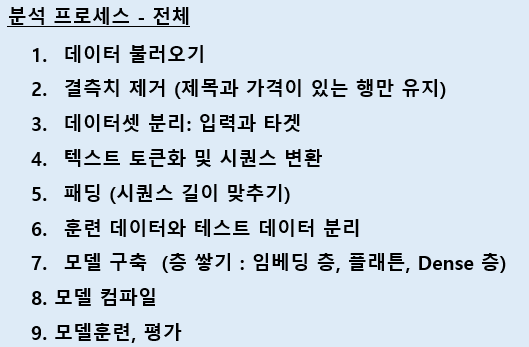

In [1]:
# 필요한 패키지 불러오지
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_1 = pd.read_csv('book.csv')

df_1.tail()

,Unnamed: 0,ID,Title,Rating,Author,Price,Pdate,Publisher,Btype,Salseindex
9996,9996,97053281,인류사를 가로지른 스마트한 발명들 50,NaN,알프리트 슈미츠,"6,700",2014년 06월 10일,서해문집,old,NaN
9997,9997,97053282,NaN,NaN,NaN,NaN,NaN,NaN,new,NaN
9998,9998,97053283,NaN,NaN,NaN,NaN,NaN,NaN,new,NaN
9999,9999,97053284,행복의 기원,NaN,서은국,"10,500",2014년 05월 22일,21세기북스,old,NaN
10000,10000,97053285,NaN,NaN,NaN,NaN,NaN,NaN,new,NaN


In [3]:
# 결측치 제거 (제목과 가격이 있는 행만 유지)
df_1.dropna(subset=['Title','Publisher','Btype','Price'], inplace=True)

# price  object => 수치형
df_1['Price'] = pd.to_numeric(df_1['Price'].str.replace('[^\d.]', ''), errors='coerce')

In [4]:
df_1['Price'].dropna(inplace=True)

In [5]:
df = df_1[df_1['Title'].str.contains('[가-힣]', regex=True)]

In [49]:
df=df_1[["Price","Title"]].dropna()

In [50]:
X = df['Title']
y = df['Price'] # 목표, 타겟, 정답, 레이블

In [51]:
df['Price'].mean()

645.4022988505748

In [52]:
lens = []
for i in df.Title.str.split(" "):
    lens.append(len(i))
print("책 최대 길이 : ", max(lens))

name_len = 24

책 최대 길이 :  11


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [54]:
# 텍스트 토큰화 및 시퀀스 변환
tokenizer = Tokenizer()
# Tokenizer 객체를 사용하여 텍스트를 토큰화, 각 토큰(단어)에 고유한 정수 인덱스 할당
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

In [55]:
len(tokenizer.word_index)

599

In [56]:
print(X.iloc[1])


삼국지 (상)


In [57]:
X_seq[0]

[31, 179, 180, 181, 182, 9]

In [58]:
# 패딩으로 시퀀스 길이 맞추기
X_pad = pad_sequences(X_seq, maxlen=name_len)

In [59]:
X_pad[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  31, 179, 180, 181, 182,   9], dtype=int32)

In [60]:
# 훈련 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [61]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   2, 156, 157, 158], dtype=int32)

In [62]:
from tensorflow.keras.layers import LSTM, Dropout

# 모델 설계, 구축
model_fnn = Sequential()

model_fnn.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=name_len))
model_fnn.add(LSTM(64))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(32, activation='relu'))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(1, activation='linear'))

model_fnn.build(input_shape=(None, name_len))
model_fnn.summary()

/home/tommy/miniconda3/envs/311/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1729859409.914864  278839 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729859409.965340  278839 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729859409.969280  278839 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://g

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 24, 128)        │        76,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,321 (501.25 KB)

 Trainable params: 128,321 (501.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# 임베딩 된 벡터 값 확인
# 모델의 임베딩 층 가중치 추출
embedding_layer_weights = model_fnn.layers[0].get_weights()[0]

# 가중치 배열의 형태 확인
print("Embedding layer weights shape:", embedding_layer_weights.shape)

# 예를 들어, 사전에 정의된 첫 번째 단어의 초기 밀집 벡터 값 확인
print("Initial vector for the first word:\n", (embedding_layer_weights.shape))

Embedding layer weights shape: (600, 128)
Initial vector for the first word:
 (600, 128)


In [64]:
# 모델 컴파일
model_fnn.compile(optimizer='adam', loss='mean_squared_error')

In [65]:
y_train

4293    400.0
2300    500.0
1021    900.0
2192    500.0
5843    900.0
        ...  
1165    900.0
4214    300.0
2310    800.0
2488    500.0
2453    900.0
Name: Price, Length: 208, dtype: float64

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStopping_ = EarlyStopping(patience=10)

# 모델 훈련
history = model_fnn.fit(X_train, y_train, epochs=100000, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping_])

Epoch 1/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 68915.5000 - val_loss: 121159.1641
Epoch 2/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 72264.3594 - val_loss: 120194.8906
Epoch 3/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 64310.4531 - val_loss: 116815.2891
Epoch 4/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 74803.9766 - val_loss: 116335.0703
Epoch 5/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 66535.0547 - val_loss: 124292.6562
Epoch 6/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78213.2344 - val_loss: 120115.1172
Epoch 7/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 54644.0312 - val_loss: 113220.5156
Epoch 8/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 69053.8281 - val_loss: 108775.9141
Epoch 9/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 66763.0625 - val_loss: 107994.4375
Epoch 10/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 52680.2266 - val_loss: 101800.6562
Epoch 11/100000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

In [67]:
loss = model_fnn.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Test Loss: 115409.46875


In [68]:
# 예측 및 평가

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 모델 평가: Keras에서 반환하는 손실값
loss = model_fnn.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# 예측값 생성
y_pred = model_fnn.predict(X_test).flatten()

# MSE 계산
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# RMSE 계산
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# R² 계산
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

Test Loss: 115409.46875
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Mean Squared Error (MSE): 115409.46921770951
Root Mean Squared Error (RMSE): 339.7196921253013
Mean Absolute Error (MAE): 299.1862030029297
R-squared (R²): -0.31450981399179967


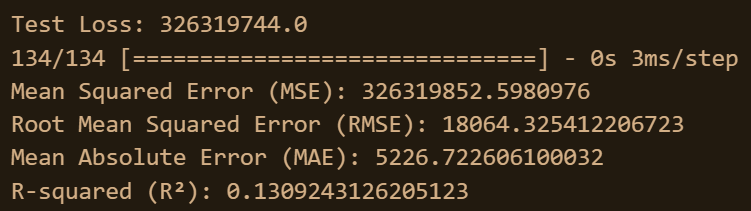

평균 가격 : 10204